# Introduction to the Iterative Quantum Phase Estimation Algorithm

#### We can run the algorithm on either an IONQ Simulator, or on an actual IONQ QPU

In [1]:
from qiskit_ionq import IonQProvider
provider = IonQProvider()

print(provider.backends())

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]


#### Import necessary libraries to define the algorithm and explore the results

In [2]:
from qiskit import *
import numpy as np
from matplotlib import pyplot as plt

#### Creates a T-gate and applies it to perform one iteration of the IPEA  

In [3]:
def buildControlledT(p, m):

    # initialize the circuit
    qc = QuantumCircuit(2, 1)

    # Hardmard on ancilla, now in |+>
    qc.h(0)

    # initialize to |1>
    qc.x(1)

    # applying T gate to qubit 1
    for i in range(2**m):
        qc.cp(np.pi/4, 0, 1)

    # phase correction
    qc.rz(p, 0)

    # inverse QFT (in other words, just measuring in the x-basis)
    qc.h(0)

    qc.measure([0],[0])

    return qc

#### The IPEA (aka iQPE or IPE) algorithm, returns the n bits needed to compute psi

In [4]:
def IPEA(k, backend_string):

    # get backend
    if backend_string == 'qpu':
        backend = provider.get_backend('ionq_qpu')
    elif backend_string == 'qasm':
        # backend = Aer.get_backend('qasm_simulator')
        backend = provider.get_backend("ionq_simulator")
    
    # bits
    bits = []

    # phase correction
    phase = 0.0
    
    # loop over iterations 
    for i in range(k-1, -1, -1):
       
        # construct the circuit
        qc = buildControlledT(phase, i)
         
        # run the circuit
        # job = execute(qc, backend)
        job = backend.run(qc, shots=10000)
        
        if backend_string == 'qpu':
            from qiskit.providers.jobstatus import JobStatus
            import time
            # Check if job is done
            while job.status() is not JobStatus.DONE:
                print("Job status is", job.status() )
                time.sleep(60)

            # grab a coffee! This can take up to a few minutes.
            # once we break out of that while loop, we know our job is finished
            print("Job status is", job.status() )
            print(job.get_counts()) # these counts are the “true” counts from the actual QPU Run
        
        # get result
        result = job.result()

        # get current bit
        this_bit = int(max(result.get_counts(), key=result.get_counts().get))
        print(result.get_counts())

        bits.append(this_bit)

        # update phase correction
        phase /= 2
        phase -= (2 * np.pi * this_bit / 4.0)

    return bits

#### Take in list of phi's and return an eigenvalue associated with |phi>

In [5]:
def eig_from_bits(bits):
    
    eig = 0.

    m = len(bits)

    # loop over all bits
    for k in range(len(bits)):
        eig += bits[k] / (2**(m-k))

    #eig *= 2*np.pi

    return eig

## Run it on the IONQ Simulator

#### Can we get our 1/8?

In [6]:
backend = 'qasm'
bits = IPEA(5, backend)
print(bits)

# re-construct energy
eig = eig_from_bits(bits)

print(eig)

{'0': np.int64(10000)}
{'0': np.int64(10000)}
{'1': np.int64(10000)}
{'0': np.int64(10000)}
{'0': np.int64(10000)}
[0, 0, 1, 0, 0]
0.125


#### What's the effect of n on the result obtained?

{'0': np.int64(8543), '1': np.int64(1457)}
{'0': np.int64(4949), '1': np.int64(5051)}
{'0': np.int64(8514), '1': np.int64(1486)}
{'1': np.int64(10000)}
{'0': np.int64(10000)}
{'0': np.int64(10000)}
{'0': np.int64(10000)}
{'1': np.int64(10000)}
{'0': np.int64(10000)}
{'0': np.int64(10000)}
{'0': np.int64(10000)}
{'0': np.int64(10000)}
{'1': np.int64(10000)}
{'0': np.int64(10000)}
{'0': np.int64(10000)}
{'0': np.int64(10000)}
{'0': np.int64(10000)}
{'0': np.int64(10000)}
{'1': np.int64(10000)}
{'0': np.int64(10000)}
{'0': np.int64(10000)}
{'0': np.int64(10000)}
{'0': np.int64(10000)}
{'0': np.int64(10000)}
{'0': np.int64(10000)}
{'1': np.int64(10000)}
{'0': np.int64(10000)}
{'0': np.int64(10000)}


Text(0.5, 1.0, '$\\phi$ vs. n')

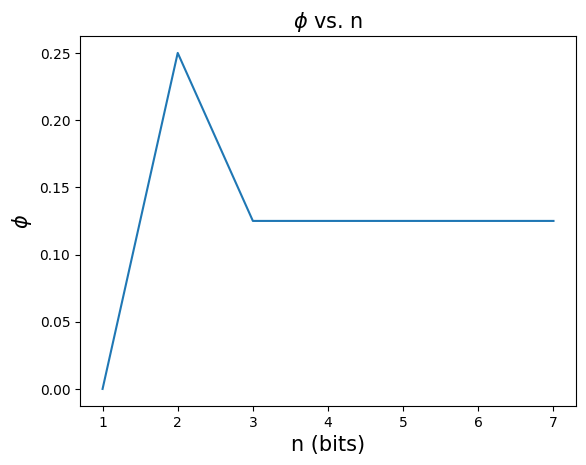

In [7]:
#perform IPEA with different values of n
n_values = []
eig_values = []
for i in range(1, 8):
    n_values.append(i)
    # perform IPEA
    backend = 'qasm'
    bits = IPEA(i, backend)

    # re-construct energy
    eig = eig_from_bits(bits)
    eig_values.append(eig)

n_values, eig_values = np.array(n_values), np.array(eig_values)
plt.plot(n_values, eig_values)
plt.xlabel('n (bits)', fontsize=15)
plt.ylabel(r'$\phi$', fontsize=15)
plt.title(r'$\phi$ vs. n', fontsize=15)

## Try it on Real IONQ Hardware

In [8]:
# perform IPEA

#backend = 'qpu'
#bits = IPEA(5, backend)
#print(bits)

# re-construct energy
#eig = eig_from_bits(bits)

#print(eig)

In [9]:
#perform IPEA with different values of n

#n_values = []
#eig_values = []
#for i in range(1, 8):
#    n_values.append(i)
    # perform IPEA
#    backend = 'qpu'
#    bits = IPEA(i, backend)

    # re-construct energy
#    eig = eig_from_bits(bits)
#    eig_values.append(eig)

#n_values, eig_values = np.array(n_values), np.array(eig_values)
#plt.plot(n_values, eig_values)
#plt.xlabel('n (bits)', fontsize=15)
#plt.ylabel(r'$\phi$', fontsize=15)
#plt.title(r'$\phi$ vs. n', fontsize=15)